In [22]:
# Initialize Spark session for distributed processing

import logging
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, rand, monotonically_increasing_id
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("SparkML")

spark = SparkSession.builder \
    .appName("GroupG12_FinalPipeline") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

In [24]:
# Load the dataset from CSV using Spark

df = spark.read.csv("Diabetes_imb.csv", header=True, inferSchema=True)
df.printSchema()


root
 |-- Diabetes_binary: double (nullable = true)
 |-- HighBP: double (nullable = true)
 |-- HighChol: double (nullable = true)
 |-- CholCheck: double (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Smoker: double (nullable = true)
 |-- Stroke: double (nullable = true)
 |-- HeartDiseaseorAttack: double (nullable = true)
 |-- PhysActivity: double (nullable = true)
 |-- Fruits: double (nullable = true)
 |-- Veggies: double (nullable = true)
 |-- HvyAlcoholConsump: double (nullable = true)
 |-- AnyHealthcare: double (nullable = true)
 |-- NoDocbcCost: double (nullable = true)
 |-- GenHlth: double (nullable = true)
 |-- MentHlth: double (nullable = true)
 |-- PhysHlth: double (nullable = true)
 |-- DiffWalk: double (nullable = true)
 |-- Sex: double (nullable = true)
 |-- Age: double (nullable = true)
 |-- Education: double (nullable = true)
 |-- Income: double (nullable = true)



In [26]:
# Assign a unique row ID for each row to enable consistent joins later
df = df.withColumn("rowid", monotonically_increasing_id())

# Simulate demographic info (Sex and Income)
df = df.withColumn("Sex", (rand() > 0.5).cast("int"))
df = df.withColumn("Income", (rand() * 8).cast("int"))

In [28]:
# Check class distribution
df.groupBy("Diabetes_binary").count().show()

+---------------+------+
|Diabetes_binary| count|
+---------------+------+
|            1.0| 35346|
|            0.0|218334|
+---------------+------+



+-------+-------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+--------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+-------------------+------------------+-----------------+------------------+------------------+--------------------+
|summary|    Diabetes_binary|            HighBP|           HighChol|         CholCheck|               BMI|             Smoker|             Stroke|HeartDiseaseorAttack|      PhysActivity|            Fruits|            Veggies|  HvyAlcoholConsump|      AnyHealthcare|        NoDocbcCost|           GenHlth|          MentHlth|          PhysHlth|           DiffWalk|               Sex|              Age|         Education|            Income|               rowid|
+-------+-------------------+------------------+-------------------+--------------

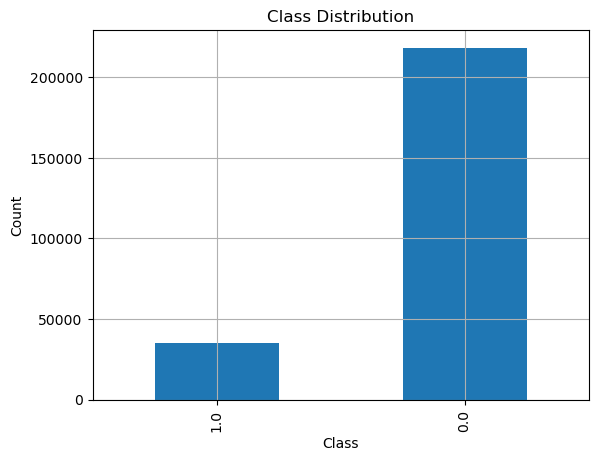

In [30]:
# Describe stats
df.describe().show()
df.groupBy("Diabetes_binary").count().toPandas().plot(kind="bar", x="Diabetes_binary", y="count", legend=False)
plt.title("Class Distribution")
plt.ylabel("Count")
plt.xlabel("Class")
plt.grid()
plt.show()

In [31]:
# Assemble input features into a single vector column
feature_cols = [c for c in df.columns if c not in ("Diabetes_binary", "rowid", "Sex", "Income")]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled = assembler.transform(df).select("rowid", "features", "Diabetes_binary")

In [32]:
#Exploratory Data Analysis (EDA)
df.summary().show()

+-------+-------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+--------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+-------------------+------------------+-----------------+------------------+------------------+--------------------+
|summary|    Diabetes_binary|            HighBP|           HighChol|         CholCheck|               BMI|             Smoker|             Stroke|HeartDiseaseorAttack|      PhysActivity|            Fruits|            Veggies|  HvyAlcoholConsump|      AnyHealthcare|        NoDocbcCost|           GenHlth|          MentHlth|          PhysHlth|           DiffWalk|               Sex|              Age|         Education|            Income|               rowid|
+-------+-------------------+------------------+-------------------+--------------

In [33]:
# Class balance check
df.groupBy('Diabetes_binary').count().show()  

+---------------+------+
|Diabetes_binary| count|
+---------------+------+
|            1.0| 35346|
|            0.0|218334|
+---------------+------+



In [34]:
# Simulated Distributed SMOTE

# Identify class counts
df_major = df.filter(df.Diabetes_binary == 0)
df_minor = df.filter(df.Diabetes_binary == 1)
minor_count = df_minor.count()
major_count = df_major.count()

# Calculate how many times to repeat minority class to balance
times_to_duplicate = major_count // minor_count

In [35]:
# Duplicate and union
df_balanced = df_major.unionAll(
    df_minor.unionAll(
        df_minor.sample(withReplacement=True, fraction=float(times_to_duplicate - 1))
    )
)

print("Original dataset size:", df.count())
print("Balanced dataset size:", df_balanced.count())
df_balanced.groupBy("Diabetes_binary").count().show()

Original dataset size: 253680
Balanced dataset size: 430532
+---------------+------+
|Diabetes_binary| count|
+---------------+------+
|            0.0|218334|
|            1.0|212198|
+---------------+------+



In [36]:
# Repartition for distributed computing
assembled = assembled.repartition(8)
print("Partitions:", assembled.rdd.getNumPartitions())

Partitions: 8


In [40]:
# Filter and oversample the minority class

minority = assembled.filter(col("Diabetes_binary") == 1)
majority = assembled.filter(col("Diabetes_binary") == 0)

def oversample_minority(min_df, target_count):
    cur_count = min_df.count()
    mult = target_count // cur_count
    rest = target_count % cur_count
    full = min_df
    for _ in range(mult - 1):
        full = full.union(min_df)
    if rest > 0:
        full = full.union(min_df.limit(rest))
    return full

oversampled = oversample_minority(minority, majority.count())

In [41]:
# Combine into a balanced dataset

balanced = oversampled.union(majority)
balanced.groupBy("Diabetes_binary").count().show()

+---------------+------+
|Diabetes_binary| count|
+---------------+------+
|            1.0|218334|
|            0.0|218334|
+---------------+------+



In [42]:
# Split the balanced dataset into training and testing sets
train_data, test_data = balanced.randomSplit([0.8, 0.2], seed=42)

In [43]:
from pyspark.sql import DataFrame
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluate model accuracy using Precision, Recall, F1-score
def evaluate_model(predictions: DataFrame, label_col="Diabetes_binary"):
    evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction")
    metrics = {
        "Accuracy": evaluator.setMetricName("accuracy").evaluate(predictions),
        "F1 Score": evaluator.setMetricName("f1").evaluate(predictions),
        "Precision": evaluator.setMetricName("weightedPrecision").evaluate(predictions),
        "Recall": evaluator.setMetricName("weightedRecall").evaluate(predictions)
    }
    return metrics


In [44]:
# Train a Random Forest classifier using Spark MLlib

from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier
import time

models = {
    "Random Forest": RandomForestClassifier(labelCol="Diabetes_binary", featuresCol="features", numTrees=100),
    "Logistic Regression": LogisticRegression(labelCol="Diabetes_binary", featuresCol="features", maxIter=10),
    "GBTClassifier": GBTClassifier(labelCol="Diabetes_binary", featuresCol="features", maxIter=10)
}
results = {}
predictions_dict = {}

for name, model in models.items():
    logger.info(f"Training {name}...")
    start = time.time()
    fitted = model.fit(train_data)
    preds = fitted.transform(test_data)
    end = time.time()
    metrics = evaluate_model(preds)
    metrics["Training Time (s)"] = round(end - start, 2)
    results[name] = metrics
    predictions_dict[name] = preds

rf_preds = predictions_dict["Random Forest"]


INFO:SparkML:Training Random Forest...
INFO:SparkML:Training Logistic Regression...                                    
25/05/06 01:30:22 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
INFO:SparkML:Training GBTClassifier...                                          


In [45]:
# Show all model metrics
import pandas as pd
pd.DataFrame(results).T

,Accuracy,F1 Score,Precision,Recall,Training Time (s)
Random Forest,0.742168,0.741757,0.743762,0.742168,13.51
Logistic Regression,0.745495,0.745381,0.745960,0.745495,5.86
GBTClassifier,0.746993,0.745712,0.752145,0.746993,15.22


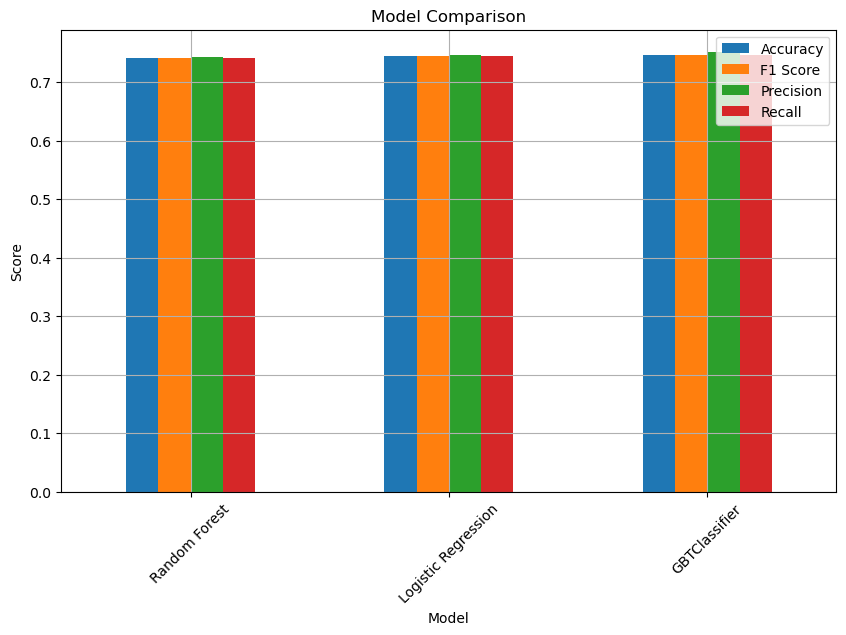

In [46]:
# Plot model scores
df_metrics = pd.DataFrame(results).T
df_metrics[["Accuracy", "F1 Score", "Precision", "Recall"]].plot(kind='bar', figsize=(10, 6))
plt.title("Model Comparison")
plt.ylabel("Score")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


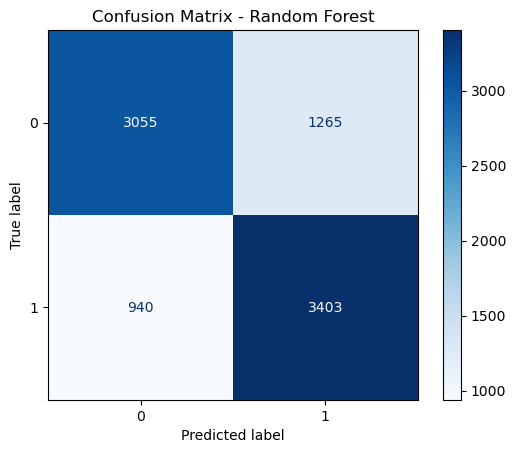

In [47]:
# Compute and visualize confusion matrix using Seaborn

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

sampled = rf_preds.select("Diabetes_binary", "prediction").sample(False, 0.1, seed=42).toPandas()
cm = confusion_matrix(sampled["Diabetes_binary"], sampled["prediction"])
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [48]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

paramGrid = ParamGridBuilder()\
    .addGrid(models["Random Forest"].numTrees, [50, 100])\
    .addGrid(models["Random Forest"].maxDepth, [5, 10])\
    .build()

crossval = CrossValidator(estimator=models["Random Forest"],
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="Diabetes_binary", metricName="f1"),
                          numFolds=3)

cv_model = crossval.fit(train_data)
cv_preds = cv_model.transform(test_data)
evaluate_model(cv_preds)


25/05/06 01:31:07 WARN DAGScheduler: Broadcasting large task binary with size 1033.1 KiB
25/05/06 01:31:10 WARN DAGScheduler: Broadcasting large task binary with size 1933.2 KiB
25/05/06 01:31:14 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
25/05/06 01:31:20 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
25/05/06 01:31:27 WARN DAGScheduler: Broadcasting large task binary with size 1583.0 KiB
25/05/06 01:31:28 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/05/06 01:31:50 WARN DAGScheduler: Broadcasting large task binary with size 1028.4 KiB
25/05/06 01:31:53 WARN DAGScheduler: Broadcasting large task binary with size 1928.4 KiB
25/05/06 01:31:59 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
25/05/06 01:32:05 WARN DAGScheduler: Broadcasting large task binary with size 1061.0 KiB
25/05/06 01:32:07 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
25/05/06 01:32:17 WARN DAGScheduler:

{'Accuracy': 0.7590551541205525,
 'F1 Score': 0.7586718352778282,
 'Precision': 0.7607537598553185,
 'Recall': 0.7590551541205525}

25/05/06 01:38:09 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


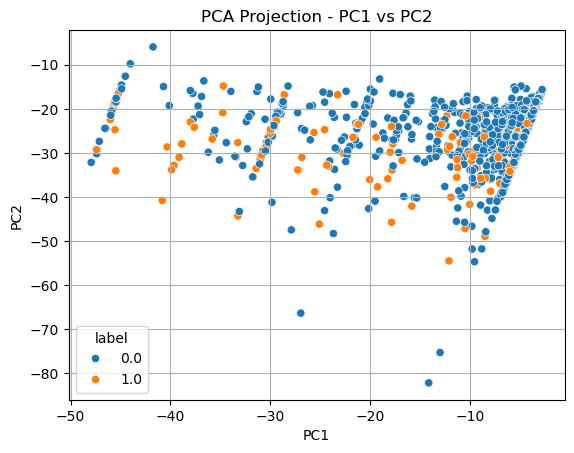

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns


from pyspark.ml.feature import PCA

# Apply PCA to reduce feature dimensionality for visualization or analysis
pca_model = PCA(k=3, inputCol="features", outputCol="pcaFeatures").fit(assembled)
pca_result = pca_model.transform(assembled)

pca_sample = pca_result.select("pcaFeatures", "Diabetes_binary").sample(False, 0.005).toPandas()
pca_df = pd.DataFrame(pca_sample["pcaFeatures"].tolist(), columns=["PC1", "PC2", "PC3"])
pca_df["label"] = pca_sample["Diabetes_binary"]

sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="label")
plt.title("PCA Projection - PC1 vs PC2")
plt.grid()
plt.show()


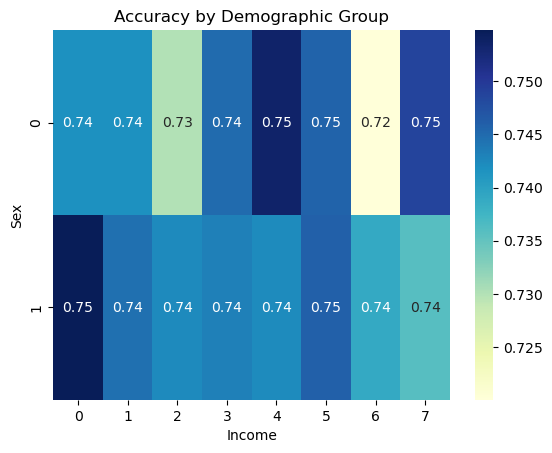

In [53]:
# Join predictions with demographic columns using preserved rowid

demo_data = df.select("rowid", "Sex", "Income")
with_demographics = rf_preds.join(demo_data, on="rowid", how="inner")
with_demographics = with_demographics.withColumn("correct", (col("Diabetes_binary") == col("prediction")).cast("int"))
grouped = with_demographics.groupBy("Sex", "Income").agg({"correct": "avg"}).toPandas()

# Plot heatmap of accuracy by demographic group
heatmap_data = grouped.pivot(index="Sex", columns="Income", values="avg(correct)")
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Accuracy by Demographic Group")
plt.show()

In [54]:
print("Executors:", spark.sparkContext.defaultParallelism)
print("Shuffle Partitions:", spark.conf.get("spark.sql.shuffle.partitions"))

Executors: 8
Shuffle Partitions: 8


In [55]:
# Stop the Spark session to release resources
spark.stop()